<a href="https://colab.research.google.com/github/Khomiakov7706/requirements_analysis/blob/develop/Requirement_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [324]:
#@title libraries import

#import os
#import sys
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

#ML libraries
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_columns', 500)

#Чтение и обработка начального текста

In [252]:
#@title Data URL. { display-mode: "form" }
data_url = 'https://raw.githubusercontent.com/Khomiakov7706/requirements_analysis/main/train_test_withcols1.csv' #@param {type: 'string'}

In [253]:
data = pd.read_csv(data_url)

In [254]:
data = data.drop('req_type', 1)
data = data.drop('test_scenario', 1)

#@title remove frase 'Verification of ' from requirements classes titles
# Iterate over the columns in the DataFrame
for column in data.columns:
    # Replace the phrase "Verification of " with an empty string
    new_column_name = column.replace("Verification of ", "")
    
    # Rename the column in the DataFrame
    data.rename(columns={column: new_column_name}, inplace=True)

data.rename(columns={'requirement': 'requirement_text',
                     'the Authentication and Authorization process': 'Authentication and Authorization',
                     'the Payment flow and details': 'Payment flow and details',
                     'the Product Page and Products': 'Product Page and Products',
                     'Security and Privacy Policy Set Up': 'Security and Privacy Policy',
                     'Integration, Maintenance of the System and Web Standards': 'Integration'
                     }, inplace=True)

In [255]:
requirement_classes = list(data.columns[2:].values)

In [256]:
data['classes_count'] = data.iloc[:, 2:].astype(bool).sum(axis=1)

# Лемматизация

In [257]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [258]:
def lemmatization(text):
    '''a function for lemmatization'''
    text = [lemmatizer.lemmatize(word.lower()) for word in text.split()]
    # joining the list of words with space separator
    return " ".join(text)

In [259]:
data['lemmatized_requirement'] = data['requirement_text'].apply(lemmatization)

Убираем стоп-слова

In [260]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [261]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words 
    text = [word for word in text.split() if word not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [262]:
data['lemmatized_requirement'] = data['lemmatized_requirement'].apply(stopwords)

In [263]:
import re
regex = re.compile('[^a-zA-Z а-яА-Я]')

In [264]:
data.lemmatized_requirement = data.lemmatized_requirement.apply(lambda x: regex.sub('',x))

# Выявление признаков из датасета

## Синтетические признаки

составляем набор признаков на основе текста Dataframe

Количество слов в тексте требования 

In [265]:
data['words_in_requirement'] = (
    data['requirement_text'].str.split().apply(len))

Кол-во слов в тексте лемматизированного требования

In [266]:
data['words_in_lemmatized_req'] = (
    data['lemmatized_requirement'].str.split().apply(len))

Кол-во исключенных слов при лемматизации

In [267]:
data['words_diffence'] = (
    data['words_in_requirement']-data['words_in_lemmatized_req'])

In [268]:
additional_parameters = data.columns[-3:]

## Формирование Bag of Words

Составляем словарь слов для разных классов с указанием количества используемых слов

In [269]:
class_dict = dict()
for c in range(len(requirement_classes)):
    class_dict[requirement_classes[c]] = data[data[requirement_classes[c]]==1]['lemmatized_requirement'].str.split(expand=True).unstack().value_counts().head(25)

Составляем мешок уникальных слов для каждого класса

In [270]:
bag_of_word = []
for i in requirement_classes:
    for j in class_dict[i].index:
        if not (j in bag_of_word):
            bag_of_word.append(j)

In [271]:
type(data)

pandas.core.frame.DataFrame

Выписываем наиболее используемые слова как признаки

In [272]:
bow_data = data.copy()
for word in bag_of_word:
    bow_data[word]=bow_data['lemmatized_requirement'].apply(lambda x: x.count(str (' ' + word + ' ')))

In [273]:
bow_data.head(1)

,req_no,requirement_text,Account Details and Settings,Authentication and Authorization,Contact Details,Customer Support,Data Integrity and Consistency,Design and Content,Downloads,Error Handling,Features and Functions,Forms and Validation of Input,Home Page,Language Compatibility,Links,Navigation,Notifications and Alerts,Password Policy and Setup,Payment flow and details,Performance,Product Page and Products,Search and Search Engine Optimization(SEO),Security and Privacy Policy,Social Media Links and Icons,Supportability and Device Compatibility,Usability and Accessibility,all Web Pages in the website,Integration,classes_count,lemmatized_requirement,words_in_requirement,words_in_lemmatized_req,words_diffence,user,contact,account,information,field,shall,number,email,profile,website,include,phone,address,id,password,form,u,page,throw,numbers,link,characters,view,create,change,system,application,able,login,authorized,access,must,register,use,data,log,administrator,support,allow,verify,cm,site,person,provide,detail,resume,company,way,customer,easily,channel,every,including,help,chatbot,service,customers,video,add,etc,make,answer,product,always,reduce,requirement,database,ensure,stored,display,document,file,table,encrypted,transaction,column,eg,update,integrity,organisation,content,image,download,different,downloadable,downloads,language,search,applicant,warranty,error,message,r,failure,priority,name,one,button,server,without,text,reported,go,item,click,tutorial,validation,enter,homepage,progress,home,instructor,bar,tab,depicts,overview,default,logo,web,available,option,url,links,navigation,navigate,main,menu,easy,component,area,category,notify,gpm,notification,buyer,sale,enable,auction,owner,security,future,notified,credit,method,creating,bidder,reset,session,never,users,payment,card,gateway,processor,may,within,time,performance,load,second,seconds,simultaneous,find,similar,show,listing,clear,price,result,searching,title,results,tag,privacy,policy,secure,social,medium,share,icon,browser,firefox,run,internet,work,need,per,class,interface,pages,shallwill,box,explains,software,management,new,standard
0,1,System shall allow users to update their billing and contact information via the “My Account” section of the website,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,system shall allow user update billing contact information via my account section website,19,13,6,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Создаем разметку данных

In [274]:
target = requirement_classes
features = bag_of_word
for i in additional_parameters:
    features.append(i)

# Разбиение на тестовую и валидационную выборки для каждого класса требований для Bag of words

Всего 26 классов

In [275]:
from sklearn.model_selection import train_test_split

In [276]:
def split_train_test (dataframe_, target_, features_):
        
        X_train, X_test, y_train, y_test = train_test_split(dataframe_[features_],dataframe_[target_],test_size=0.2, random_state=77, stratify=dataframe_[target_])
        
        return X_train, X_test, y_train, y_test

In [277]:
for cl in requirement_classes:
  print(cl, '\n', class_dict[cl].value_counts(),'\n\n')

Account Details and Settings 
 6     8
4     7
5     3
7     2
27    1
23    1
17    1
12    1
11    1
dtype: int64 


Authentication and Authorization 
 12     5
13     4
32     2
28     2
15     2
14     2
130    1
40     1
36     1
33     1
31     1
27     1
26     1
17     1
dtype: int64 


Contact Details 
 5     5
11    4
6     4
10    2
9     2
7     2
57    1
26    1
23    1
22    1
17    1
13    1
dtype: int64 


Customer Support 
 5     9
7     4
6     4
8     2
26    1
23    1
22    1
12    1
11    1
9     1
dtype: int64 


Data Integrity and Consistency 
 7     5
5     5
4     4
51    1
35    1
30    1
29    1
19    1
15    1
14    1
13    1
11    1
9     1
6     1
dtype: int64 


Design and Content 
 26     3
23     3
100    2
19     2
61     1
48     1
43     1
41     1
40     1
89     1
33     1
32     1
28     1
63     1
25     1
24     1
68     1
21     1
36     1
dtype: int64 


Downloads 
 6     7
5     5
7     3
4     3
8     2
15    1
13    1
12    1
10    1
9     

In [278]:
X_class_train = dict()
X_class_test = dict()
y_class_train = dict()
y_class_test = dict()

for cl in requirement_classes:
    X_class_train[cl],X_class_test[cl],y_class_train[cl],y_class_test[cl]=split_train_test(dataframe_=bow_data, target_=cl, features_=class_dict[cl].index)

# Нормализация

Нормализация обучающей выборки

In [279]:
scaler = dict()
scaler_params = dict()
for cl in requirement_classes:
    scaler[cl] = MinMaxScaler()
    X_class_train[cl] = scaler[cl].fit_transform(X_class_train[cl])

Нормализация тестовой выборки на сонове парамтеров обучающей

In [280]:
scaler_ = MinMaxScaler()
for cl in requirement_classes:
#    scaler[cl].get_params()
    X_class_test[cl]=scaler[cl].transform(X_class_test[cl])

# Обучение модели на базе Bag Of Words

Так как классификация будет проводиться по каждому из классов независимо, разбиение на тестовую и обучающую выборки будет проводиться для каждого из классов отдельно

In [281]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
model_class_lr = dict()
model_lr_ = LogisticRegression() # Используем модель с параметрами по умолчанию

for cl in range(len(requirement_classes)):
    model_lr_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_lr[requirement_classes[cl]] = model_lr_

Наивный Байес

In [282]:
from sklearn.naive_bayes import GaussianNB
model_nb_ = GaussianNB() # Используем модель с параметрами по умолчанию

model_class_nb = dict()
for cl in range(len(requirement_classes)):
    model_nb_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_nb[requirement_classes[cl]] = model_nb_

k-ближайших соседей

In [283]:
from sklearn.neighbors import KNeighborsClassifier
model_knn_ = KNeighborsClassifier() # Используем модель с параметрами по умолчанию

model_class_knn = dict()
for cl in range(len(requirement_classes)):
    model_knn_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_knn[requirement_classes[cl]] = model_knn_

Метод решающих деревьев

In [284]:
from sklearn.tree import DecisionTreeClassifier
model_dtc_ = DecisionTreeClassifier() # Используем модель с параметрами по умолчанию

model_class_dtc = dict()
for cl in range(len(requirement_classes)):
    model_dtc_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_dtc[requirement_classes[cl]] = model_dtc_

Метод поддерживающих векторов

In [285]:
from sklearn.svm import SVC
model_svc_ = SVC() # Используем модель с параметрами по умолчанию

model_class_svc = dict()
for cl in range(len(requirement_classes)):
    model_svc_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_svc[requirement_classes[cl]] = model_svc_

Случайный лес

In [286]:
from sklearn.ensemble import RandomForestClassifier
model_rf_ = RandomForestClassifier() # Используем модель с параметрами по умолчанию

model_class_rf = dict()
for cl in range(len(requirement_classes)):
    model_rf_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_rf[requirement_classes[cl]] = model_rf_

In [287]:
classifier_models = { 'nb' : model_class_nb,
                     'knn' : model_class_knn,
                     'lr' : model_class_lr,
                     'dtc' : model_class_dtc,
                     'svc' : model_class_svc,
                     'rf' : model_class_rf
                     }

## Расчет accuracy and confusion matrix метрик для каждого класса и метода

In [288]:
from sklearn.metrics import accuracy_score

In [289]:
#@title linear regression

lr_accuracy_test = dict()
lr_accuracy_train = dict()
lr_train_confusion_matrix = dict()
lr_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_lr[cl].predict(X_class_train[cl])
    test_predict = model_class_lr[cl].predict(X_class_test[cl])

    lr_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    lr_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)

    lr_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    lr_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
    

In [290]:
#@title naive bias

nb_accuracy_test = dict()
nb_accuracy_train = dict()
nb_train_confusion_matrix = dict()
nb_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_nb[cl].predict(X_class_train[cl])
    test_predict = model_class_nb[cl].predict(X_class_test[cl])

    nb_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    nb_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)

    nb_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    nb_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
    

In [291]:
#@title k nearest neighbours

knn_accuracy_test = dict()
knn_accuracy_train = dict()

knn_train_confusion_matrix = dict()
knn_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_knn[cl].predict(X_class_train[cl])
    test_predict = model_class_knn[cl].predict(X_class_test[cl])

    knn_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    knn_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)
    
    knn_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    knn_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)

In [292]:
#@title decision trees


dtc_accuracy_test = dict()
dtc_accuracy_train = dict()
dtc_train_confusion_matrix = dict()
dtc_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_dtc[cl].predict(X_class_train[cl])
    test_predict = model_class_dtc[cl].predict(X_class_test[cl])

    dtc_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    dtc_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)

    dtc_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    dtc_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
    

In [293]:
#@title support vector machine

svc_accuracy_test = dict()
svc_accuracy_train = dict()
svc_train_confusion_matrix = dict()
svc_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_svc[cl].predict(X_class_train[cl])
    test_predict = model_class_svc[cl].predict(X_class_test[cl])

    svc_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    svc_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)
    
    svc_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    svc_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
  

In [294]:
#@title random forest

rf_accuracy_test = dict()
rf_accuracy_train = dict()
rf_train_confusion_matrix = dict()
rf_test_confusion_matrix = dict()

for cl in requirement_classes:
  train_predict = model_class_rf[cl].predict(X_class_train[cl])
  test_predict = model_class_rf[cl].predict(X_class_test[cl])
  
  rf_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
  rf_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)
  
  rf_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
  rf_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
    

## Confusion matrix

In [295]:
#@title variables declaration
classifiers = list({'lr', 'nb', 'knn', 'dtc', 'svc', 'rf'})
mean_train_accuracy = dict()
mean_test_accuracy = dict()

for i in classifiers:
    mean_train_accuracy[i] = 0.0
    mean_test_accuracy[i] = 0.0

In [296]:
#@title Confusion matrix function definition
cf = dict()
def confusion_matrix_by_classifier (classifier, confusion_matrix):
  cf[classifier] = 0
  for cl in requirement_classes:
    cf[classifier] += confusion_matrix[cl]
  print('confusion matrix for ', classifier, ' classifier:\n', cf[classifier], '\n')

In [297]:
#@title Confusion Matrixes for different classifiers
lr_confusionMatrix = confusion_matrix_by_classifier('lr', lr_test_confusion_matrix)
nb_confusionMatrix = confusion_matrix_by_classifier('nb', nb_test_confusion_matrix)
svc_confusionMatrix = confusion_matrix_by_classifier('svc', svc_test_confusion_matrix)
rf_confusionMatrix = confusion_matrix_by_classifier('rf', rf_test_confusion_matrix)
dtc_confusion_matrix = confusion_matrix_by_classifier('dtc', dtc_test_confusion_matrix)
knn_confusion_matrix = confusion_matrix_by_classifier('knn', knn_test_confusion_matrix)

confusion matrix for  lr  classifier:
 [[6759   28]
 [ 411   30]] 

confusion matrix for  nb  classifier:
 [[5461 1326]
 [ 216  225]] 

confusion matrix for  svc  classifier:
 [[6687  100]
 [ 436    5]] 

confusion matrix for  rf  classifier:
 [[6428  359]
 [ 385   56]] 

confusion matrix for  dtc  classifier:
 [[6301  486]
 [ 370   71]] 

confusion matrix for  knn  classifier:
 [[6568  219]
 [ 404   37]] 



##Mean Accuracy

In [298]:
#@title logistic regression
print('Логистическая регрессия')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',lr_accuracy_train[cl])
    print('Точность на тестовой выборке: ', lr_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['lr'] += lr_accuracy_train[cl]
    mean_test_accuracy['lr'] += lr_accuracy_test[cl]

mean_train_accuracy['lr'] = mean_train_accuracy['lr']/len(requirement_classes)
mean_test_accuracy['lr'] = mean_test_accuracy['lr']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['lr'])
print ('mean test accuracy: ', mean_test_accuracy['lr'])

Логистическая регрессия
mean train accuracy:  0.9396098505810737
mean test accuracy:  0.939263973436635


In [299]:
#@title naive bias

print('Наивный Байес')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',nb_accuracy_train[cl])
    print('Точность на тестовой выборке: ', nb_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['nb'] += nb_accuracy_train[cl]
    mean_test_accuracy['nb'] += nb_accuracy_test[cl]
mean_train_accuracy['nb'] = mean_train_accuracy['nb']/len(requirement_classes)
mean_test_accuracy['nb'] = mean_test_accuracy['nb']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['nb'])
print ('mean test accuracy: ', mean_test_accuracy['nb'])

Наивный Байес
mean train accuracy:  0.7811635307138902
mean test accuracy:  0.7866629773104593


In [300]:
#@title KNN

print('k-ближайших соседей')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',knn_accuracy_train[cl])
    print('Точность на тестовой выборке: ', knn_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['knn'] += knn_accuracy_train[cl]
    mean_test_accuracy['knn'] += knn_accuracy_test[cl]
mean_train_accuracy['knn'] = mean_train_accuracy['knn']/len(requirement_classes)
mean_test_accuracy['knn'] = mean_test_accuracy['knn']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['knn'])
print ('mean test accuracy: ', mean_test_accuracy['knn'])

k-ближайших соседей
mean train accuracy:  0.9113516878804648
mean test accuracy:  0.9138074156059767


In [301]:
#@title decision trees

print('Метод решающих деревьев')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',dtc_accuracy_train[cl])
    print('Точность на тестовой выборке: ', dtc_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['dtc'] += dtc_accuracy_train[cl]
    mean_test_accuracy['dtc'] += dtc_accuracy_test[cl]
mean_train_accuracy['dtc'] = mean_train_accuracy['dtc']/len(requirement_classes)
mean_test_accuracy['dtc'] = mean_test_accuracy['dtc']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['dtc'])
print ('mean test accuracy: ', mean_test_accuracy['dtc'])

Метод решающих деревьев
mean train accuracy:  0.8799806308799114
mean test accuracy:  0.8815716657443275


In [302]:
#@title support vector machine)

print('Метод опорных векторов')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',svc_accuracy_train[cl])
    print('Точность на тестовой выборке: ', svc_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['svc'] += svc_accuracy_train[cl]
    mean_test_accuracy['svc'] += svc_accuracy_test[cl]
mean_train_accuracy['svc'] = mean_train_accuracy['svc']/len(requirement_classes)
mean_test_accuracy['svc'] = mean_test_accuracy['svc']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['svc'])
print ('mean test accuracy: ', mean_test_accuracy['svc'])

Метод опорных векторов
mean train accuracy:  0.9262244050913112
mean test accuracy:  0.9258439402324292


In [303]:
#@title random forest

print('Случайный лес')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',rf_accuracy_train[cl])
    print('Точность на тестовой выборке: ', rf_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['rf'] += rf_accuracy_train[cl]
    mean_test_accuracy['rf'] += rf_accuracy_test[cl]
mean_train_accuracy['rf'] = mean_train_accuracy['rf']/len(requirement_classes)
mean_test_accuracy['rf'] = mean_test_accuracy['rf']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['rf'])
print ('mean test accuracy: ', mean_test_accuracy['rf'])

Случайный лес
mean train accuracy:  0.8984504703929164
mean test accuracy:  0.8970669618151633


##Precision

In [304]:
# Define the dictionary to store Precision metric for each classifier
precision_metrics = {}

# Iterate over each classifier and its predictions
for classifier_name in classifiers:
    precision_metrics[classifier_name] = 0
    for cl in requirement_classes:
      test_predict = classifier_models[classifier_name][cl].predict(X_class_test[cl])
      
      precision_metrics[classifier_name] += metrics.precision_score(y_class_test[cl], test_predict)
    
    precision_metrics[classifier_name] = precision_metrics[classifier_name]/len(requirement_classes)
    print("precision for ", classifier_name, '\n', precision_metrics[classifier_name], '\n')

precision for  dtc 
 0.13400953365595572 

precision for  svc 
 0.09615384615384616 

precision for  knn 
 0.1889252031493411 

precision for  rf 
 0.1469588495698491 

precision for  nb 
 0.1486702551836583 

precision for  lr 
 0.33186813186813185 



##Recall

In [305]:
# Define the dictionary to store Recall metric for each classifier
recall_metrics = {}

# Iterate over each classifier and its predictions
for classifier_name in classifiers:
    recall_metrics[classifier_name] = 0
    for cl in requirement_classes:
        test_predict = classifier_models[classifier_name][cl].predict(X_class_test[cl])
        recall_metrics[classifier_name] += metrics.recall_score(y_class_test[cl], test_predict)

    recall_metrics[classifier_name] = recall_metrics[classifier_name] / len(requirement_classes)
    print("Recall for", classifier_name, ":\n", recall_metrics[classifier_name], "\n")


Recall for dtc :
 0.16889921837632854 

Recall for svc :
 0.006418581418581418 

Recall for knn :
 0.11930867935092543 

Recall for rf :
 0.15869590155527982 

Recall for nb :
 0.6289199713536038 

Recall for lr :
 0.11950782754323294 



##F1

In [306]:
# Define the dictionary to store F1 metric for each classifier
f1_metrics = {}

# Iterate over each classifier and its predictions
for classifier_name in classifiers:
    f1_metrics[classifier_name] = 0
    for cl in requirement_classes:
        test_predict = classifier_models[classifier_name][cl].predict(X_class_test[cl])
        f1_metrics[classifier_name] += metrics.f1_score(y_class_test[cl], test_predict)
    
    f1_metrics[classifier_name] = f1_metrics[classifier_name] / len(requirement_classes)
    print("F1 metric for", classifier_name, ":", f1_metrics[classifier_name])


F1 metric for dtc : 0.1291518804549025
F1 metric for svc : 0.011930522592954535
F1 metric for knn : 0.1219176318441815
F1 metric for rf : 0.13460047173071574
F1 metric for nb : 0.2183484447747447
F1 metric for lr : 0.1619223290041107


## Визуализация результатовб полученных на основе BOW

методом линейной регрессии получилась следующая точность классификации для каждого класса:

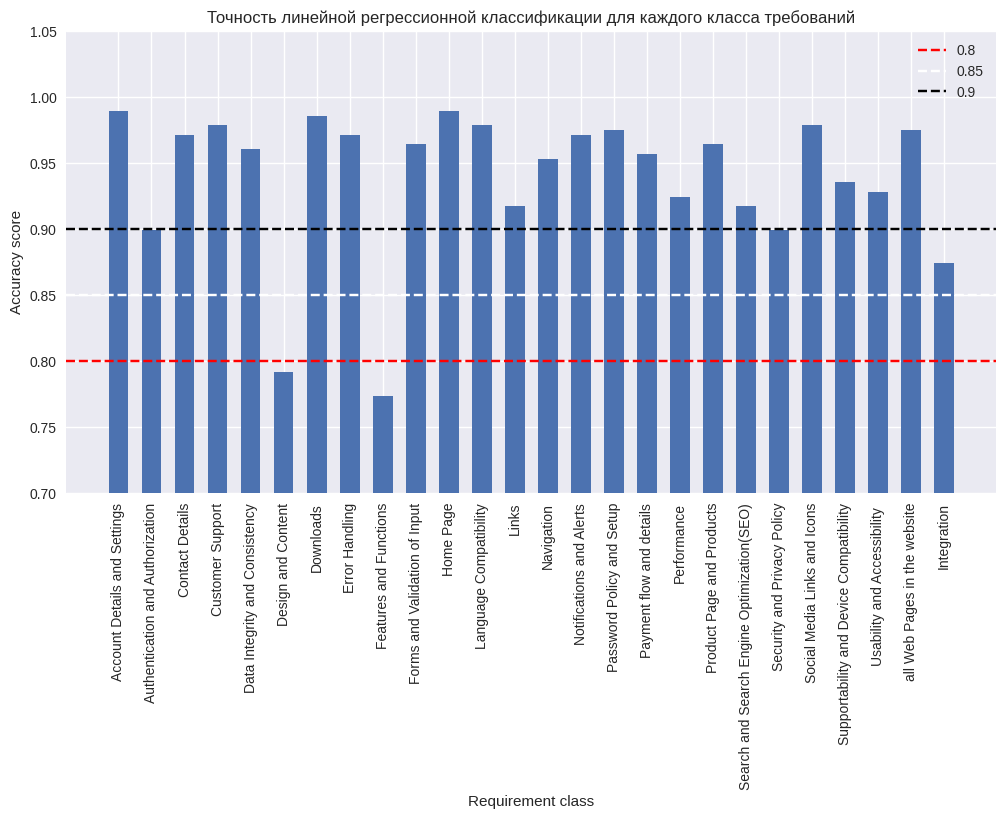

In [307]:
plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(requirement_classes,lr_accuracy_test.values(), width=0.6)
plt.title('Точность линейной регрессионной классификации для каждого класса требований')
a = plt.xticks(rotation=90)
plt.axhline(0.8,c='r',linestyle='--',label='0.8')
plt.axhline(0.85,c='w',linestyle='--',label='0.85')
plt.axhline(0.9,c='black',linestyle='--',label='0.9')
plt.ylim(0.7, 1.05) # adjust y axis limits
plt.legend()
plt.xlabel('Requirement class')
plt.ylabel('Accuracy score')
plt.show()

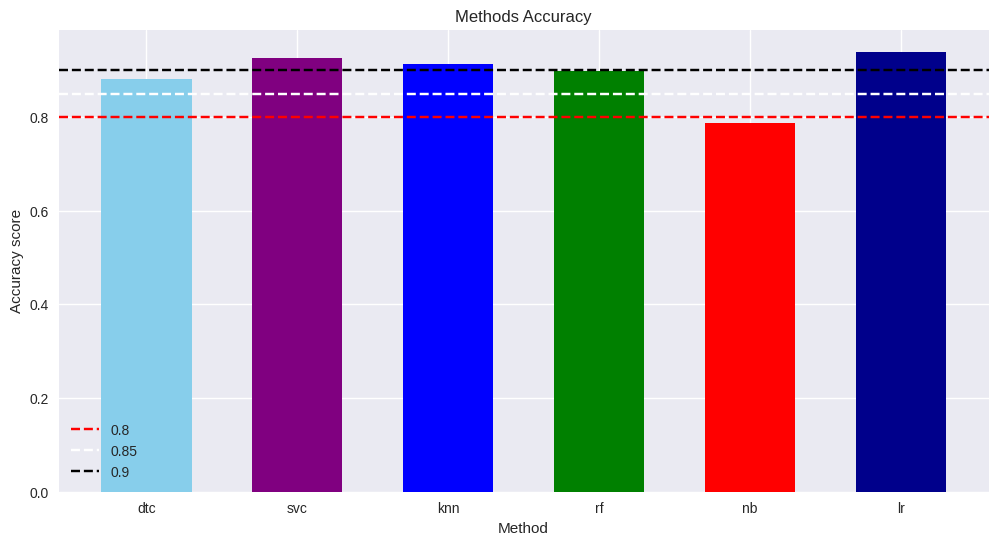

In [308]:
plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(classifiers,mean_test_accuracy.values(),width=0.6, color={'red','green','blue','purple', 'skyblue','darkblue'})
plt.title('Methods Accuracy')
plt.axhline(0.8,c='r',linestyle='--',label='0.8')
plt.axhline(0.85,c='w',linestyle='--',label='0.85')
plt.axhline(0.9,c='black',linestyle='--',label='0.9')
plt.legend()
plt.autoscale()
plt.xlabel('Method')
plt.ylabel('Accuracy score')
plt.show()

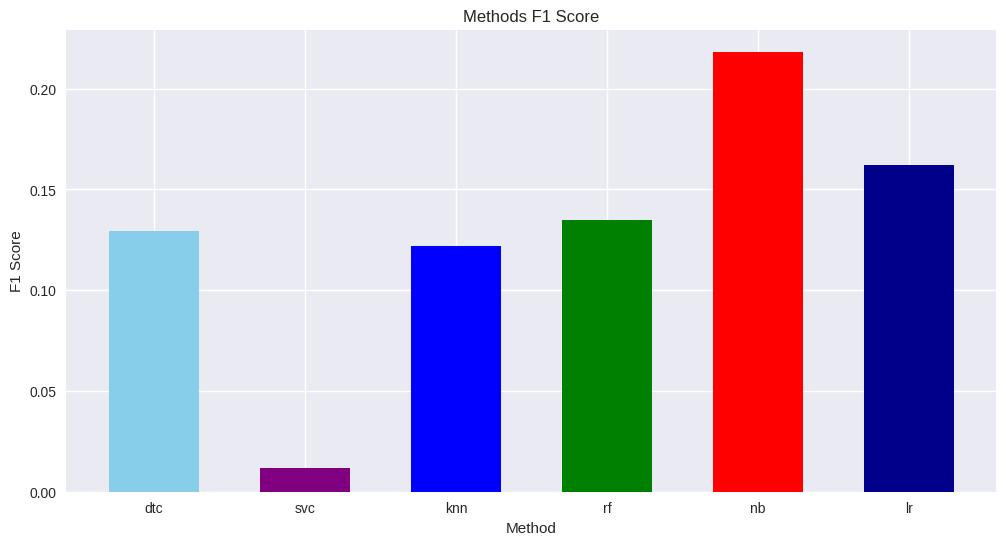

In [309]:
plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(classifiers, f1_metrics.values(), width=0.6, color={'red','green','blue','purple', 'skyblue','darkblue'})
plt.title('Methods F1 Score')
plt.legend()
plt.autoscale()
plt.xlabel('Method')
plt.ylabel('F1 Score')
plt.show()


In [310]:
print ('method', '\t', 'train accuracy', '\t', 'test accuracy', '\n')
for i in classifiers:
    print (i, '\t', mean_train_accuracy[i], '\t', mean_test_accuracy[i])

method 	 train accuracy 	 test accuracy 

dtc 	 0.8799806308799114 	 0.8815716657443275
svc 	 0.9262244050913112 	 0.9258439402324292
knn 	 0.9113516878804648 	 0.9138074156059767
rf 	 0.8984504703929164 	 0.8970669618151633
nb 	 0.7811635307138902 	 0.7866629773104593
lr 	 0.9396098505810737 	 0.939263973436635


#CountVectorizer model



In [312]:
#@title train test split with the help of function split_train_test

X_class_train = dict()
X_class_test = dict()
y_class_train = dict()
y_class_test = dict()

for cl in requirement_classes:
    X_class_train[cl],X_class_test[cl],y_class_train[cl],y_class_test[cl]=split_train_test(dataframe_=data, target_=cl, features_='lemmatized_requirement')

In [325]:
#@title initialize and transform CountVectorizers for each classification task
# Initialize a CountVectorizer object: count_vectorizer
count_train = dict()
count_test = dict()
count_vectorizers = dict()


for cl in requirement_classes:

  count_vectorizers[cl] = CountVectorizer(stop_words="english")
  
  # Transform the training data using only the 'text' column values: count_train 
  count_train[cl] = count_vectorizers[cl].fit_transform(X_class_train[cl])

  # Transform the test data using only the 'text' column values: count_test 
  count_test[cl] = count_vectorizers[cl].transform(X_class_test[cl])

In [ ]:
# Initialize a dictionary to store classifiers
classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a Multinomial Naive Bayes classifier for the current task
    nb_classifier = MultinomialNB()
  
    # Fit the classifier to the training data for the current task
    nb_classifier.fit(count_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    classifiers[cl] = nb_classifier

# Create a dictionary to store predicted tags for each classification task
pred = {}

# Create a dictionary to store accuracy scores for each classification task
scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
precision = {}
recall = {}
f1_score = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Predict the tags for the test data of the current task
    pred[cl] = classifiers[cl].predict(count_test[cl])
  
    # Calculate the accuracy score for the current task
    scores[cl] = metrics.accuracy_score(y_class_test[cl], pred[cl])
    print("Accuracy score for", cl, ":", scores[cl])

    # Calculate the confusion matrix for the current task
    cms[cl] = metrics.confusion_matrix(y_class_test[cl], pred[cl], labels=[1, 0])
    print("Confusion matrix for", cl, ":\n", cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    precision[cl] = metrics.precision_score(y_class_test[cl], pred[cl])
    recall[cl] = metrics.recall_score(y_class_test[cl], pred[cl])
    f1_score[cl] = metrics.f1_score(y_class_test[cl], pred[cl])

    print("Precision for", cl, ":", precision[cl])
    print("Recall for", cl, ":", recall[cl])
    print("F1-score for", cl, ":", f1_score[cl], '\n')

In [339]:
# Sort the f1_score dictionary based on F1-score values in descending order
sorted_scores = sorted(f1_score.items(), key=lambda x: x[1], reverse=True)

# Print the titles and scores in descending order
print("F1-scores in descending order:")
for title, score in sorted_scores:
    print(title, "F1-score:", score)

F1-scores in descending order:
Error Handling F1-score: 0.7499999999999999
Payment flow and details F1-score: 0.7368421052631577
Search and Search Engine Optimization(SEO) F1-score: 0.7142857142857143
Supportability and Device Compatibility F1-score: 0.6666666666666667
Links F1-score: 0.6521739130434783
Integration F1-score: 0.626865671641791
Features and Functions F1-score: 0.6065573770491803
Design and Content F1-score: 0.5925925925925927
Social Media Links and Icons F1-score: 0.5714285714285715
Password Policy and Setup F1-score: 0.5454545454545454
Performance F1-score: 0.5294117647058824
Security and Privacy Policy F1-score: 0.5217391304347826
Navigation F1-score: 0.5
Authentication and Authorization F1-score: 0.4782608695652174
Data Integrity and Consistency F1-score: 0.47619047619047616
Contact Details F1-score: 0.4
Downloads F1-score: 0.33333333333333337
Product Page and Products F1-score: 0.33333333333333337
Customer Support F1-score: 0.2857142857142857
Forms and Validation of 

In [350]:
f1_score

{'Account Details and Settings': 0.0,
 'Authentication and Authorization': 0.4782608695652174,
 'Contact Details': 0.4,
 'Customer Support': 0.2857142857142857,
 'Data Integrity and Consistency': 0.47619047619047616,
 'Design and Content': 0.5925925925925927,
 'Downloads': 0.33333333333333337,
 'Error Handling': 0.7499999999999999,
 'Features and Functions': 0.6065573770491803,
 'Forms and Validation of Input': 0.25000000000000006,
 'Home Page': 0.22222222222222224,
 'Language Compatibility': 0.0,
 'Links': 0.6521739130434783,
 'Navigation': 0.5,
 'Notifications and Alerts': 0.1818181818181818,
 'Password Policy and Setup': 0.5454545454545454,
 'Payment flow and details': 0.7368421052631577,
 'Performance': 0.5294117647058824,
 'Product Page and Products': 0.33333333333333337,
 'Search and Search Engine Optimization(SEO)': 0.7142857142857143,
 'Security and Privacy Policy': 0.5217391304347826,
 'Social Media Links and Icons': 0.5714285714285715,
 'Supportability and Device Compatibilit

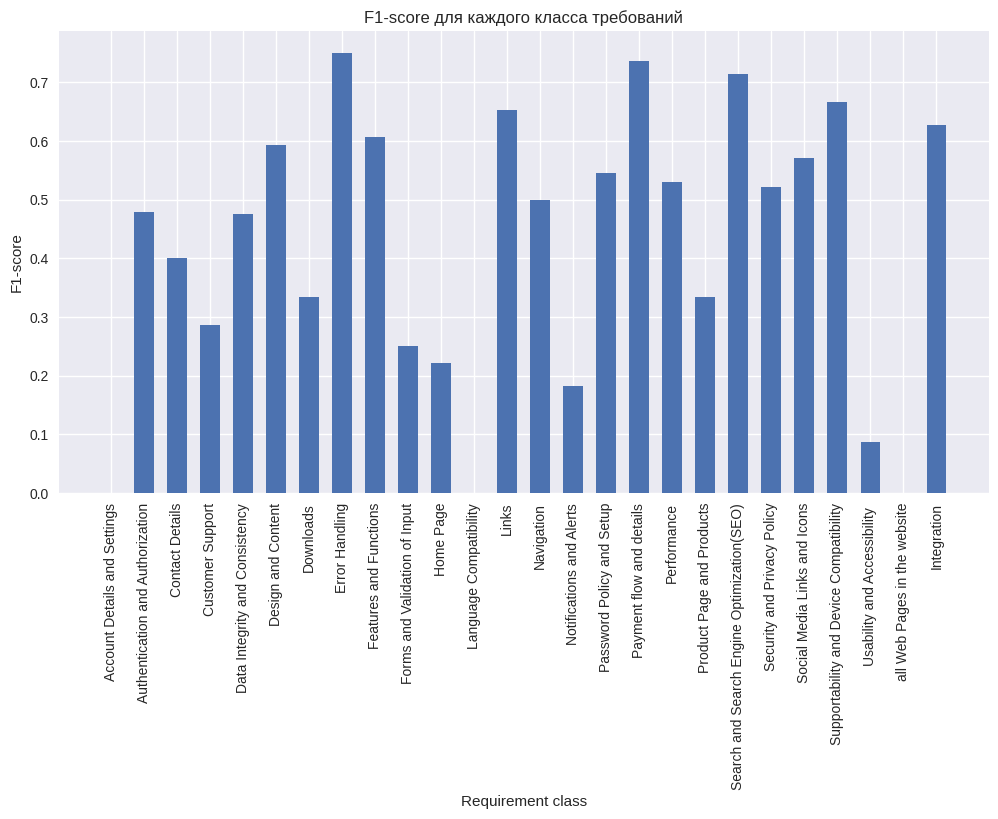

In [351]:
plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(f1_score.keys(), f1_score.values(), width=0.6)
plt.title('F1-score для каждого класса требований')
plt.xticks(rotation=90)
#plt.axhline(0.8, c='r', linestyle='--', label='0.8')
#plt.axhline(0.85, c='w', linestyle='--', label='0.85')
#plt.axhline(0.9, c='black', linestyle='--', label='0.9')
plt.autoscale()
plt.legend()
plt.xlabel('Requirement class')
plt.ylabel('F1-score')
plt.show()
